# Code Similarity: A Machine Learning Project

## Project Inicialization

In [136]:
import json, time, os
from parser.parser import *
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

PROJECTS_FOLDER = f'{os.getcwd()}/Projects/'

DATA_FOLDER = f'{os.getcwd()}/data/'

os.makedirs(DATA_FOLDER, exist_ok=True)
pd.set_option('display.max_columns', None)


## Extrayendo Los AST

In [137]:

# PROJECTS_FOLDER = f'{os.getcwd()}/Projects/'

# DATA_FOLDER = f'{os.getcwd()}/data/'

# os.makedirs(DATA_FOLDER, exist_ok=True)

# project_features = []

# for f in os.scandir(PROJECTS_FOLDER):
#     if f.is_dir():
#         print(PROJECTS_FOLDER + f.name)
        
#         features = process_project(PROJECTS_FOLDER + f.name)
#         features['project_name'] = f.name
#         project_features.append(features)

# # Generar un nombre de archivo JSON único usando la marca de tiempo
# timestamp = time.strftime("%Y%m%d-%H%M%S")
# output_json_path = os.path.join(DATA_FOLDER, f"features_{timestamp}.json")

# # Guardar los features en un archivo JSON
# with open(output_json_path, 'w', encoding='utf-8') as json_file:
#     json.dump(project_features, json_file, ensure_ascii=False, indent=4)
  

## Features Extraídos y su Importancia:

1. **`total_nodes`**
   - **Descripción**: Número total de nodos visitados en el árbol de sintaxis.
   - **Importancia**: Indica el tamaño del código fuente y la complejidad general del análisis.

2. **`node_count`**
   - **Descripción**: Diccionario que mantiene el conteo de cada tipo de nodo encontrado.
   - **Importancia**: Permite identificar qué tipos de constructos de lenguaje se utilizan más frecuentemente.

3. **`max_depth`**
   - **Descripción**: Profundidad máxima alcanzada en el árbol de sintaxis.
   - **Importancia**: Una mayor profundidad puede indicar una estructura de código más compleja y anidada.

4. **`variables`**
   - **Descripción**: Número de variables declaradas en el código.
   - **Importancia**: Indica la cantidad de almacenamiento local usado, lo cual puede reflejar la complejidad del estado manejado por el programa.

5. **`constants`**
   - **Descripción**: Número de constantes declaradas.
   - **Importancia**: Las constantes pueden indicar valores inmutables importantes y buenas prácticas de programación.

6. **`out_variables`**
   - **Descripción**: Número de variables de salida (out) declaradas.
   - **Importancia**: Las variables de salida son importantes para el flujo de datos y la gestión de resultados en métodos.

7. **`methods`**
   - **Descripción**: Número de métodos definidos.
   - **Importancia**: Ayuda a medir la modularidad y el tamaño funcional del código.

8. **`classes`**
   - **Descripción**: Número de clases definidas.
   - **Importancia**: Permite entender la estructura orientada a objetos del código.

9. **`interfaces`**
   - **Descripción**: Número de interfaces definidas.
   - **Importancia**: Las interfaces son cruciales para la abstracción y la definición de contratos en programación orientada a objetos.

10. **`abstract_classes`**
    - **Descripción**: Número de clases abstractas definidas.
    - **Importancia**: Las clases abstractas indican puntos de extensión y abstracción.

11. **`sealed_classes`**
    - **Descripción**: Número de clases selladas definidas.
    - **Importancia**: Las clases selladas indican clases que no pueden ser heredadas, lo cual puede ser útil para seguridad y optimización.

12. **`import_statements`**
    - **Descripción**: Número de declaraciones de importación (`using`).
    - **Importancia**: Refleja las dependencias y bibliotecas externas utilizadas en el código.

13. **`function_calls`**
    - **Descripción**: Número de llamadas a funciones.
    - **Importancia**: Indica el uso y la frecuencia de las funciones en el código.

14. **`try_catch_blocks`**
    - **Descripción**: Número de bloques try-catch.
    - **Importancia**: Refleja el manejo de excepciones y la robustez del código ante errores.

15. **`lists`**
    - **Descripción**: Número de listas utilizadas en el código.
    - **Importancia**: Las listas son estructuras de datos importantes y su uso puede indicar la gestión de colecciones.

16. **`dicts`**
    - **Descripción**: Número de diccionarios utilizados en el código.
    - **Importancia**: Los diccionarios son estructuras de datos importantes para el almacenamiento de pares clave-valor.

17. **`variable_names`**
    - **Descripción**: Conjunto de nombres de variables únicas.
    - **Importancia**: Ayuda a la identificación y análisis de la nomenclatura y la reutilización de nombres.

18. **`method_names`**
    - **Descripción**: Conjunto de nombres de métodos únicos.
    - **Importancia**: Útil para la identificación y análisis de la nomenclatura de métodos.

19. **`method_lengths`**
    - **Descripción**: Lista con la longitud de cada método.
    - **Importancia**: Métodos más largos pueden ser más complejos y difíciles de mantener.

20. **`class_names`**
    - **Descripción**: Conjunto de nombres de clases únicas.
    - **Importancia**: Ayuda a la identificación y análisis de la nomenclatura de clases.

21. **`interface_names`**
    - **Descripción**: Conjunto de nombres de interfaces únicas.
    - **Importancia**: Útil para la identificación y análisis de la nomenclatura de interfaces.

22. **`enum_names`**
    - **Descripción**: Conjunto de nombres de enumeraciones únicas.
    - **Importancia**: Mejora la legibilidad y la mantenibilidad del código, indicando constantes relacionadas.

23. **`delegate_names`**
    - **Descripción**: Conjunto de nombres de delegados únicos.
    - **Importancia**: Facilita la comprensión y el seguimiento de las referencias de métodos pasados como argumentos.

24. **`distinct_tokens`**
    - **Descripción**: Diccionario de tokens distintos y su conteo.
    - **Importancia**: Permite comprender la diversidad y la frecuencia de los tokens utilizados en el código.

25. **`control_structures`**
    - **Descripción**: Diccionario que cuenta las estructuras de control (`if`, `switch`, `for`, `while`, `dowhile`).
    - **Importancia**: Ayuda a entender el flujo lógico y las decisiones en el código.

26. **`access_modifiers_methods`**
    - **Descripción**: Diccionario que cuenta los modificadores de acceso en métodos (`public`, `private`, `protected`, etc.).
    - **Importancia**: Los modificadores indican la visibilidad y el control de acceso de los métodos, crucial para la encapsulación y la seguridad del código.

27. **`other_modifiers`**
    - **Descripción**: Diccionario que cuenta otros modificadores (`readonly`, `volatile`, `virtual`, `override`, etc.).
    - **Importancia**: Indican comportamientos especiales de métodos y variables, afectando la semántica y optimización del código.

28. **`library_calls`**
    - **Descripción**: Diccionario que cuenta las llamadas a ciertas bibliotecas (`Console`, `Math`).
    - **Importancia**: Refleja el uso de bibliotecas estándar y puede indicar dependencias clave en el código.

29. **`linq_queries`**
    - **Descripción**: Diccionario que cuenta las diferentes consultas LINQ utilizadas (`Select`, `Where`, `OrderBy`, etc.).
    - **Importancia**: LINQ es una característica poderosa en C# para manejar colecciones y datos, y su uso puede indicar un enfoque funcional en el código.

30. **`method_return_types`**
    - **Descripción**: Diccionario que almacena los tipos de retorno de los métodos.
    - **Importancia**: Permite comprender los tipos de datos devueltos por los métodos, lo cual es crucial para el análisis de tipos y la comprensión del flujo de datos.

31. **`method_parameters`**
    - **Descripción**: Diccionario que almacena los parámetros de los métodos.
    - **Importancia**: Proporciona información sobre la firma de los métodos, ayudando a entender cómo se intercambian los datos en el programa.

32. **`number_of_enums`**
    - **Descripción**: Número de enumeraciones (enum) definidas.
    - **Importancia**: Los enums proporcionan una manera de definir conjuntos de constantes relacionadas, mejorando la legibilidad y la mantenibilidad del código.

33. **`number_of_delegates`**
    - **Descripción**: Número de delegados definidos.
    - **Importancia**: Los delegados son tipos que representan referencias a métodos, permitiendo pasar métodos como argumentos.  

34. **`number_of_lambdas`**
   - **Descripción**: Número de expresiones lambda utilizadas.
   - **Importancia**: Las expresiones lambda son una forma concisa de escribir métodos anónimos y son clave para la programación funcional y las consultas LINQ.

35. **`number_of_getters_setters`**
   - **Descripción**: Número de getters y setters definidos en propiedades.
   - **Importancia**: Los getters y setters controlan el acceso a los datos de una clase y son esenciales para la encapsulación y la validación de datos.

36. **`number_of_tuples`**
   - **Descripción**: Número de tuplas utilizadas.
   - **Importancia**: Las tuplas son útiles para devolver múltiples valores de un método y pueden simplificar la estructura de datos en el código.

37. **`number_of_namespaces`**
    - **Descripción**: Número de espacios de nombres definidos.
    - **Importancia**: Los espacios de nombres organizan el código en grupos lógicos y evitan conflictos de nombres.


## MOSS Baseline

## Data Loading

In [138]:
raw_data = pd.read_json('data/merged_features.json')
raw_data.head()


,total_nodes,max_depth,number_of_variables,number_of_constants,out_variables,ref_params,number_of_methods,number_of_classes,number_of_interfaces,number_of_abstract_classes,number_of_sealed_classes,import_statements,number_of_try_blocks,number_of_lists,number_of_dictionaries,number_of_enums,number_of_delegates,function_calls,control_structures_if,control_structures_switch,control_structures_for,control_structures_while,control_structures_dowhile,access_modifiers_public,access_modifiers_private,access_modifiers_protected,access_modifiers_internal,access_modifiers_static,access_modifiers_protected_internal,access_modifiers_private_protected,modifier_readonly,modifier_volatile,modifier_virtual,modifier_override,modifier_new,modifier_partial,modifier_extern,modifier_unsafe,modifier_async,linq_querie_select,linq_queries_where,linq_queries_orderBy,linq_queries_groupBy,linq_queries_join,linq_queries_sum,linq_queries_count,library_call_console,library_call_math,number_of_lambdas,number_of_getters,number_of_setters,number_of_tuples,number_of_namespaces,node_count,project_name,label,variable_names_vector,delegate_names_vector,method_return_types_vector,method_names_vector,class_names_vector,interface_names_vector,enums_names_vector,method_parameters_vector
0,50910,929,99,0,0,0,62,35,0,0,0,13,9,7,1,0,0,79,136,12,17,1,0,123,28,3,0,8,0,0,0,0,0,28,29,0,0,0,0,0,0,0,0,0,3,0,2,6,6,14,11,0,9,"{'Compilation_unitContext': 17, 'Using_directi...",Ramonconda_HulkProjec,original,"[0.29003021121025, -0.056365694850683004]",[],"[0.23114159703254702, -0.081178113818168]","[0.18955948948860102, 0.031225629150867]","[0.102172762155532, -0.074847757816314]",[],[],"[0.33499601483345004, 0.164041638374328, 0.504..."
1,22004,830,26,5,0,0,33,12,0,0,0,11,4,0,0,0,0,26,25,0,5,0,0,60,54,4,7,19,0,0,25,0,0,11,22,0,0,0,0,4,4,0,0,0,13,0,1,9,17,7,4,0,12,"{'Compilation_unitContext': 15, 'Using_directi...",0mar-rivero_moogle-2021,original,"[0.17961211502552002, 0.30988132953643804]",[],"[-0.08988583087921101, 0.011347159743309]","[-0.004444234073162, 0.09193804860115001]","[0.16748221218585901, 0.001231367350555]",[],[],"[-0.041170533746480005, 0.08922655135393101, 0..."
2,38989,549,106,0,0,0,36,7,0,0,0,6,1,2,4,1,0,105,85,5,2,13,0,51,11,0,0,2,0,0,0,0,0,0,20,0,0,0,0,0,0,0,0,0,30,0,5,6,0,6,3,0,7,"{'Compilation_unitContext': 7, 'Using_directiv...",kmy-cyber_INTERPRETE-C--to-HULK,original,"[-0.08906488865613901, 0.015095226466655001]",[],"[-0.021856937557458003, 0.051118414849042004]","[-0.050317630171775006, -0.05181847512722]","[-0.011356943286955001, 0.052615948021411]",[],"[0.358630090951919, 0.370688110589981]","[-0.087587870657444, -0.09872957319021201, 0.0..."
3,33435,859,109,0,0,0,28,9,0,0,0,1,0,3,1,0,0,44,69,0,41,0,0,73,1,0,0,54,0,0,0,0,0,0,17,0,0,0,0,0,0,0,0,0,2,0,0,6,0,32,31,1,9,"{'Compilation_unitContext': 10, 'Using_directi...",RodryJR_moogle,original,"[0.11038670688867501, 0.12858112156391102]",[],"[0.105059131979942, 0.14119260013103402]","[0.036629255861043, 0.014120348729193]","[0.165928900241851, 0.030856110155582]",[],[],"[-0.0027547003701320003, 0.016020303592085002,..."
4,14984,323,94,0,0,0,18,4,0,0,0,1,0,19,8,0,0,20,6,0,30,0,0,29,2,0,0,19,0,0,0,0,0,0,23,0,0,0,0,0,0,0,0,1,31,0,0,2,6,5,4,0,4,"{'Compilation_unitContext': 6, 'Using_directiv...",Gelita04_moogle,original,"[0.05122560635209, 0.059940546751022006]",[],"[0.023615883663296002, 0.15818928182125]","[-0.071763359010219, 0.056835789233446]","[-0.075979679822921, 0.203354522585868]",[],[],"[-0.088068060576915, 0.05758874863386101, -0.2..."


In [139]:
# Step 1: Identify columns with list values dynamically
list_columns = [col for col in raw_data.columns if isinstance(raw_data[col].iloc[0], list)]

# Step 2-4: Expand and concatenate for each list column
for list_column in list_columns:
    # Expand the lists into multiple columns
    expanded_cols = pd.DataFrame(raw_data[list_column].tolist(), index=raw_data.index)
    
    # Rename the expanded columns to match desired output
    expanded_cols.columns = [f'{list_column}-{i+1}' for i in range(expanded_cols.shape[1])]
    
    # Drop the original list column and concatenate the expanded columns
    raw_data = raw_data.drop(columns=[list_column]).join(expanded_cols)

# Replace NaN with appropriate values if needed (e.g., 0 or '')
raw_data = raw_data.fillna(np.nan)  # Or any other value like 0 or ''

# raw_data[['interface_names_vector-1', 'project_name', 'label']]

raw_data = raw_data.drop(columns = ['label', 'delegate_names_vector-1', 'delegate_names_vector-2', 'node_count', 'project_name', 'modifier_volatile', 'access_modifiers_private_protected', 'access_modifiers_protected_internal', 'control_structures_dowhile', 'number_of_sealed_classes', 'modifier_volatile', 'modifier_unsafe', 'linq_queries_groupBy', 'linq_queries_count'])
raw_data = raw_data.fillna(0)
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 61 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   total_nodes                   77 non-null     int64  
 1   max_depth                     77 non-null     int64  
 2   number_of_variables           77 non-null     int64  
 3   number_of_constants           77 non-null     int64  
 4   out_variables                 77 non-null     int64  
 5   ref_params                    77 non-null     int64  
 6   number_of_methods             77 non-null     int64  
 7   number_of_classes             77 non-null     int64  
 8   number_of_interfaces          77 non-null     int64  
 9   number_of_abstract_classes    77 non-null     int64  
 10  import_statements             77 non-null     int64  
 11  number_of_try_blocks          77 non-null     int64  
 12  number_of_lists               77 non-null     int64  
 13  number_

## Difference Data

In [140]:
import itertools
# from listener import 

numeric_data = raw_data.select_dtypes(include=['float64', 'int64'])
component_wise_differences = []
# TODO: Get project name from original data
for (index1, row1), (index2, row2) in itertools.combinations(numeric_data.iterrows(), 2):
    difference = row1.values - row2.values
    component_wise_differences.append([index1, index2] + list(difference))
columns = ['Index1', 'Index2'] + list(numeric_data.columns)
component_wise_df = pd.DataFrame(component_wise_differences, columns=columns)
component_wise_df

component_wise_df.head()

,Index1,Index2,total_nodes,max_depth,number_of_variables,number_of_constants,out_variables,ref_params,number_of_methods,number_of_classes,number_of_interfaces,number_of_abstract_classes,import_statements,number_of_try_blocks,number_of_lists,number_of_dictionaries,number_of_enums,number_of_delegates,function_calls,control_structures_if,control_structures_switch,control_structures_for,control_structures_while,access_modifiers_public,access_modifiers_private,access_modifiers_protected,access_modifiers_internal,access_modifiers_static,modifier_readonly,modifier_virtual,modifier_override,modifier_new,modifier_partial,modifier_extern,modifier_async,linq_querie_select,linq_queries_where,linq_queries_orderBy,linq_queries_join,linq_queries_sum,library_call_console,library_call_math,number_of_lambdas,number_of_getters,number_of_setters,number_of_tuples,number_of_namespaces,variable_names_vector-1,variable_names_vector-2,method_return_types_vector-1,method_return_types_vector-2,method_names_vector-1,method_names_vector-2,class_names_vector-1,class_names_vector-2,interface_names_vector-1,interface_names_vector-2,enums_names_vector-1,enums_names_vector-2,method_parameters_vector-1,method_parameters_vector-2,method_parameters_vector-3,method_parameters_vector-4
0,0,1,28906.0,99.0,73.0,-5.0,0.0,0.0,29.0,23.0,0.0,0.0,2.0,5.0,7.0,1.0,0.0,0.0,53.0,111.0,12.0,12.0,1.0,63.0,-26.0,-1.0,-7.0,-11.0,-25.0,0.0,17.0,7.0,0.0,0.0,0.0,-4.0,-4.0,0.0,0.0,-10.0,1.0,-3.0,-11.0,7.0,7.0,0.0,-3.0,0.110418,-0.366247,0.321027,-0.092525,0.194004,-0.060712,-0.065309,-0.076079,0.0,0.0,0.000000,0.000000,0.376167,0.074815,0.368926,-0.054263
1,0,2,11921.0,380.0,-7.0,0.0,0.0,0.0,26.0,28.0,0.0,0.0,7.0,8.0,5.0,-3.0,-1.0,0.0,-26.0,51.0,7.0,15.0,-12.0,72.0,17.0,3.0,0.0,6.0,0.0,0.0,28.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-27.0,-3.0,0.0,6.0,8.0,8.0,0.0,2.0,0.379095,-0.071461,0.252999,-0.132297,0.239877,0.083044,0.113530,-0.127464,0.0,0.0,-0.358630,-0.370688,0.422584,0.262771,0.494429,-0.089456
2,0,3,17475.0,70.0,-10.0,0.0,0.0,0.0,34.0,26.0,0.0,0.0,12.0,9.0,4.0,0.0,0.0,0.0,35.0,67.0,12.0,-24.0,1.0,50.0,27.0,3.0,0.0,-46.0,0.0,0.0,28.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,6.0,-18.0,-20.0,-1.0,0.0,0.179644,-0.184947,0.126082,-0.222371,0.152930,0.017105,-0.063756,-0.105704,0.0,0.0,0.000000,0.000000,0.337751,0.148021,0.642351,0.170806
3,0,4,35926.0,606.0,5.0,0.0,0.0,0.0,44.0,31.0,0.0,0.0,12.0,9.0,-12.0,-7.0,0.0,0.0,59.0,130.0,12.0,-13.0,1.0,94.0,26.0,3.0,0.0,-11.0,0.0,0.0,28.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-28.0,2.0,4.0,0.0,9.0,7.0,0.0,5.0,0.238805,-0.116306,0.207526,-0.239367,0.261323,-0.025610,0.178152,-0.278202,0.0,0.0,0.000000,0.000000,0.423064,0.106453,0.711089,0.221846
4,0,5,25177.0,538.0,46.0,0.0,0.0,0.0,56.0,28.0,0.0,0.0,9.0,9.0,6.0,1.0,-1.0,0.0,40.0,90.0,12.0,11.0,0.0,99.0,19.0,3.0,0.0,-7.0,0.0,-1.0,28.0,-5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-5.0,6.0,6.0,9.0,11.0,0.0,3.0,0.309323,-0.110510,0.249601,-0.202551,0.144960,0.003423,0.128183,-0.171091,0.0,0.0,-0.217687,-0.032332,0.271451,0.188448,0.464603,-0.041570


## Selecting Data

In [141]:
data = component_wise_df
# data = raw_data

## Processing data

In [142]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Index1,2926.0,25.000000,18.030838,0.000000,10.000000,22.000000,38.000000,75.000000
Index2,2926.0,51.000000,18.030838,1.000000,38.000000,54.000000,66.000000,76.000000
total_nodes,2926.0,-586.185236,55826.491558,-244064.000000,-25458.500000,-1970.500000,20661.000000,251609.000000
max_depth,2926.0,-280.176350,1387.771469,-4456.000000,-755.500000,-144.500000,355.000000,4181.000000
number_of_variables,2926.0,11.453178,161.647876,-851.000000,-48.000000,0.000000,51.000000,876.000000
...,...,...,...,...,...,...,...,...
enums_names_vector-2,2926.0,-0.020760,0.240629,-0.933802,-0.164303,0.000000,0.089725,0.861012
method_parameters_vector-1,2926.0,-0.026255,0.335425,-1.506672,-0.106768,-0.015815,0.089499,1.216597
method_parameters_vector-2,2926.0,-0.003352,0.183790,-0.836531,-0.085584,-0.000129,0.090576,0.747255
method_parameters_vector-3,2926.0,-0.014485,0.346517,-1.303098,-0.190556,-0.007632,0.184523,1.126912


In [143]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2926 entries, 0 to 2925
Data columns (total 63 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Index1                        2926 non-null   int64  
 1   Index2                        2926 non-null   int64  
 2   total_nodes                   2926 non-null   float64
 3   max_depth                     2926 non-null   float64
 4   number_of_variables           2926 non-null   float64
 5   number_of_constants           2926 non-null   float64
 6   out_variables                 2926 non-null   float64
 7   ref_params                    2926 non-null   float64
 8   number_of_methods             2926 non-null   float64
 9   number_of_classes             2926 non-null   float64
 10  number_of_interfaces          2926 non-null   float64
 11  number_of_abstract_classes    2926 non-null   float64
 12  import_statements             2926 non-null   float64
 13  num

## Clustering

### K-Means

In [144]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Seleccionar columnas numéricas
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Normalizar los datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(numeric_data)

# Definir el número de clusters
num_clusters = 2

# Crear y ajustar el modelo K-Means
wcss = []
for i in range(1, 500):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=1)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Añadir las etiquetas de los clusters al DataFrame original
# data['Cluster'] = kmeans.labels_





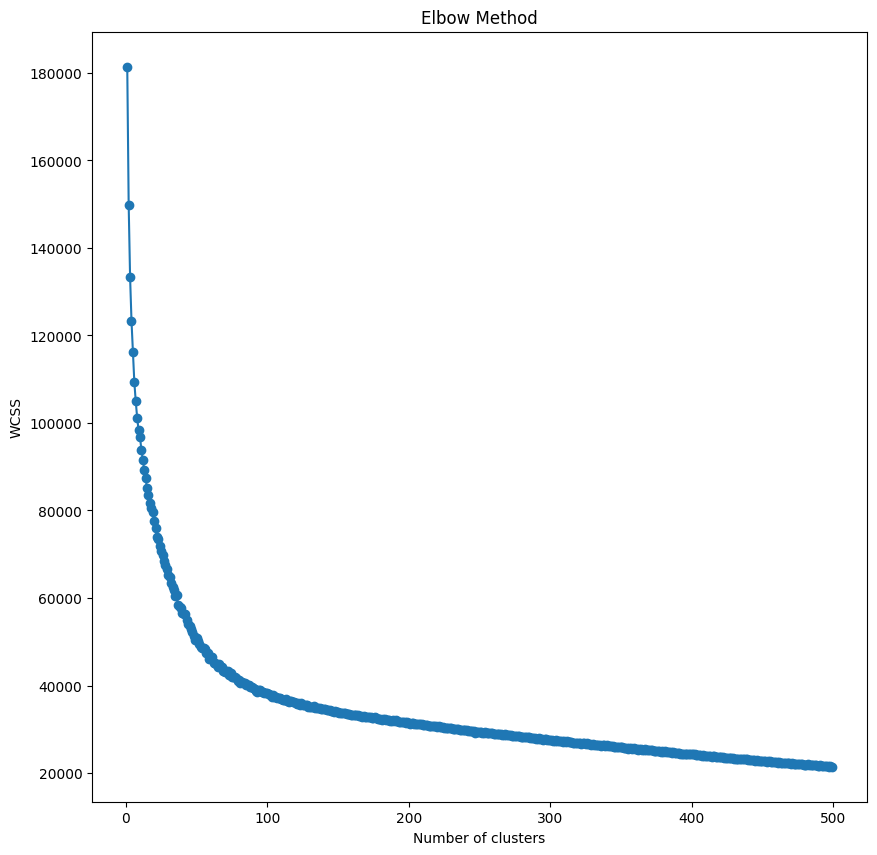

In [145]:
# Elbow method plotting
plt.figure(figsize=(10,10))
plt.plot(range(1, 500), wcss, marker = 'o')
plt.title("Elbow Method")
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.show()

In [146]:
# Create a pairplot with the specified colors
# sns.pairplot(component_wise_df, hue='Cluster', palette='tab10')
# plt.show()

### Agglomerative Clustering

In [134]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)

# Z = linkage(scaled_data, method='ward', metric='euclidean')

# plt.figure(figsize=(10, 6))
# dendrogram(Z, labels=data.index.values, orientation='top')
# plt.title("Dendogram")
# plt.xlabel("Pair of programs")
# plt.ylabel("Distance")
# plt.xticks(rotation=90)
# plt.tight_layout()
# plt.show()

In [135]:
from sklearn.cluster import AgglomerativeClustering

cluster_ward_5 = AgglomerativeClustering(n_clusters=5, linkage='ward')
cluster_ward_2 = AgglomerativeClustering(n_clusters=2, linkage='ward')

y_ward_5 = cluster_ward_5.fit_predict(scaled_data)
y_ward_2 = cluster_ward_2.fit_predict(scaled_data)

data['agglomerative_ward_2'] = y_ward_2
data['agglomerative_ward_5'] = y_ward_5

In [ ]:
# Create a pairplot with the specified colors
sns.pairplot(data, hue='agglomerative_ward_5', palette='viridis')
plt.show()

## Siamese NN

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from SNN.siamese_network_parse import PrepareDataSNN

# Definir la arquitectura base
def create_base_network(input_shape):
    input = Input(shape=input_shape)
    x = Dense(128, activation='relu')(input)
    x = Dense(128, activation='relu')(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)

# Definir la función de distancia
def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))

# Crear el modelo de red siamesa
def create_siamese_network(input_shape):
    base_network = create_base_network(input_shape)

    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Obtener las representaciones de las dos ramas
    processed_a = base_network(input_a)
    processed_b = base_network(input_b)

    # Calcular la distancia entre las dos salidas
    distance = Lambda(euclidean_distance, output_shape=(1,))([processed_a, processed_b])

    model = Model([input_a, input_b], distance)
    return model

# Definir la función de pérdida
def contrastive_loss(y_true, y_pred):
    margin = 1
    square_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# Entrenar el modelo
def train_siamese_network(data_a, data_b, labels):
    input_shape = (data_a.shape[1],)
    model = create_siamese_network(input_shape)

    model.compile(loss=contrastive_loss, optimizer=Adam(learning_rate=0.001))

    model.fit([data_a, data_b], labels, batch_size=128, epochs=20)

# Ejecutar el entrenamiento
if __name__ == "__main__":
    data = PrepareDataSNN()
    data_a, data_b, labels = data.process()
    train_siamese_network(data_a, data_b, labels)


In [ ]:
import networkx as nx
from antlr4 import *
from antlr4 import CommonTokenStream
from Python.CSharpLexer import CSharpLexer
from Python.CSharpParser import CSharpParser
import json, os
import matplotlib.pyplot as plt
from networkx.drawing.nx_agraph import to_agraph

class ASTToGraphVisitor:
    def __init__(self):
        self.graph = nx.DiGraph()  # Usamos un grafo dirigido
        self.node_count = 0

    def next_node_id(self):
        self.node_count += 1
        return self.node_count

    def add_node(self, node, label):
        node_id = self.next_node_id()
        self.graph.add_node(node_id, label=label)
        return node_id

    def visitChildren(self, node):
        current_node_id = self.add_node(node, type(node).__name__)
        for child in node.getChildren():
            if isinstance(child, TerminalNode):
                child_id = self.add_node(child, child.getText())
            else:
                child_id = self.visitChildren(child)
            self.graph.add_edge(current_node_id, child_id)
        return current_node_id

# Método para convertir un AST a un grafo
def convert_ast_to_graph(input_code):
    input_stream = InputStream(input_code)
    lexer = CSharpLexer(input_stream)
    stream = CommonTokenStream(lexer)
    parser = CSharpParser(stream)
    tree = parser.compilation_unit()  # Cambia 'startRule' por la regla inicial de tu gramática

    visitor = ASTToGraphVisitor()
    visitor.visitChildren(tree)
    return visitor.graph

# Método para dibujar el grafo utilizando matplotlib
def draw_graph(graph):
    agraph = to_agraph(graph)
    agraph.layout(prog='dot')  # Usar el motor 'dot' para el posicionamiento
    agraph.draw('ast_graph.png')  # Guardar el grafo como imagen PNG

json_file_path = f'{os.getcwd()}/Projects/All/Ab3lucho_Moogle/Moogle-main/MoogleEngine/Query.cs'


with open(json_file_path, 'r') as file:
    code = file.read()
        
graph = convert_ast_to_graph(code)

# Imprimir el grafo
print(len(graph.nodes))
print(graph.nodes(data=True))
print(graph.edges())




In [ ]:
# Visualizar el grafo
draw_graph(graph)